### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv('E:/hw8_processed_data_with_new_features.csv', index_col='id')

In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 41 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   passenger_count     1312780 non-null  float64
 2   store_and_fwd_flag  1458644 non-null  int64  
 3   distance_km         1312780 non-null  float64
 4   log_trip_duration   1458644 non-null  float64
 5   anomaly             1458644 non-null  int64  
 6   traffic_jam         1458644 non-null  int64  
 7   day_of_week_1       1458644 non-null  int64  
 8   day_of_week_2       1458644 non-null  int64  
 9   day_of_week_3       1458644 non-null  int64  
 10  day_of_week_4       1458644 non-null  int64  
 11  day_of_week_5       1458644 non-null  int64  
 12  day_of_week_6       1458644 non-null  int64  
 13  hour_1              1458644 non-null  int64  
 14  hour_2              1458644 non-null  int64  
 15  hour_3    

Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [4]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

### Your code is here
data['passenger_count'].isnull().sum() #145864
data['distance_km'].isnull().sum() #145864

145864

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [5]:
### Your code is here
data['passenger_count'].value_counts() #930.4
data['passenger_count'] = data['passenger_count'].fillna(930.40)
data['passenger_count'].unique()

array([ 930.39975328,  930.4       , 1061.35522314, 1053.52974933,
       1005.45833452, 1028.23627621, 1070.23217396, 1718.43333333,
         19.66666667,  560.        ,  104.        ])

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [6]:
### Your code is here
slot = data.groupby(['vendor_id', 'store_and_fwd_flag', 'traffic_jam', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6'])['distance_km'].transform("mean")
data['distance_km'] = data['distance_km'].fillna(slot)


In [6]:
### Убедимся, что пропусков не осталось

### Your code is here
data.head(20).to_csv('E:/hw_8.csv', sep=';', index=False)

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [25]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)


from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here
from sklearn.model_selection import train_test_split

X = data.drop('log_trip_duration', axis=1)
Y = data['log_trip_duration']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=42)
selector.split(X) 

model = LinearRegression()

cross_val_error = []
losses_train = []

for train_index, test_index in selector.split(X):
    X_train_c, X_test_c = X.values[train_index], X.values[test_index]
    Y_train, Y_test = Y.values[train_index], Y.values[test_index]
    model.fit(X_train_c, Y_train)
    
    cross_val_error.append(np.mean(((model.predict(X_test_c) - Y_test)**2)))
    losses_train.append(np.mean(((model.predict(X_train_c) - Y_train)**2)))

round(np.mean(cross_val_error ), 4)
#print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

0.4309

In [36]:
X.shape[0]

1458644

### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

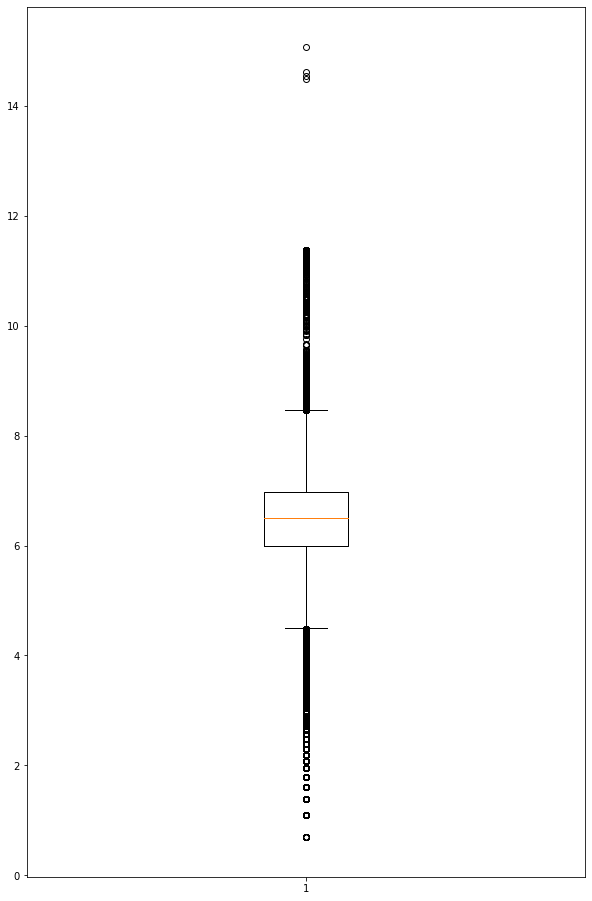

In [47]:
import matplotlib.pyplot as plt

### Your code is here
fig = plt.figure()
fig.set_size_inches((10, 16))
plt.boxplot(data['log_trip_duration'].values)

plt.show()

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [16]:
### Your code is here

high = data['log_trip_duration'].quantile(0.995) #квантили это нижняя и верхняя грани коробки! не усов
low = data['log_trip_duration'].quantile(0.05) 

#r = high - low
#u_tent = high + 1.5*r
#l_tent = low - 1.5*r

In [17]:
data1 = data[(data['log_trip_duration'] < high)&(data['log_trip_duration'] > low)]

X_1, Y_1 = data1.drop('log_trip_duration', axis=1), data1['log_trip_duration']

Снова замерьте качество на кросс-валидации, используя старый selector

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
model = LinearRegression()
selector = KFold(n_splits=4, shuffle=True, random_state=33)

result_cleaned = cross_validate(model, X_1, Y_1, 
                                scoring='neg_mean_squared_error',
                                cv=selector)
msle_cleaned = -result_cleaned['test_score'].mean()

print("MSLE (очищенные данные):", msle_cleaned)


MSLE (очищенные данные): 0.2513667160609415
